In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import copy
import numpy as np
import os
import joblib

In [4]:
data = pd.read_csv(r'data\StudentsPerformance.csv')
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


### Создадим модель на изначальных данных, посмотрим какую точноть она получит, а потом попытаемся улучшить результат

In [6]:
data2 = data.copy()
data2["gender"] = pd.Categorical(data2["gender"]).codes
data2["race/ethnicity"] = pd.Categorical(data2["race/ethnicity"]).codes
data2["lunch"] = pd.Categorical(data2["lunch"]).codes
data2["test preparation course"] = pd.Categorical(data2["test preparation course"]).codes
data2["parental level of education"] = pd.Categorical(data2["parental level of education"]).codes
data2.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,0,1,1,1,1,72,72,74
1,0,2,4,1,0,69,90,88
2,0,1,3,1,1,90,95,93
3,1,0,0,0,1,47,57,44
4,1,2,4,1,1,76,78,75


In [7]:
data_X = data2[['gender', 'parental level of education', 'test preparation course']]
data_Y = data2[['math score', 'reading score', 'writing score']]
X_train, x_test, Y_train, y_test = train_test_split(data_X, data_Y, test_size=20, random_state=42)


In [8]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Количество деревьев в лесу
    'max_depth': [None, 10, 20, 30],  # Максимальная глубина дерева
    'min_samples_split': [2, 5, 10],  # Минимальное количество образцов для разделения узла
    'min_samples_leaf': [1, 2, 4]     # Минимальное количество образцов в листе
}

In [9]:
if not os.path.exists("model_RF_izn.pkl"):
    model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, n_jobs= -1, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, Y_train)
    best_rf = grid_search.best_estimator_
    joblib.dump(best_rf, "model_RF_izn.pkl")
else:
    model = joblib.load("model_RF_izn.pkl")


In [10]:
# Оценка на тестовых данных
y_pred = model.predict(x_test)

# Вычисление MSE на тестовых данных
mse = mean_squared_error(y_test, y_pred)
print(f"Test Mean Squared Error: {mse}")

# Прогнозы на основе среднего значения для каждой целевой переменной
baseline_pred_math = np.full_like(y_test["math score"], np.mean(Y_train["math score"]), dtype=float)
baseline_pred_reading = np.full_like(y_test["reading score"], np.mean(Y_train["reading score"]), dtype=float)
baseline_pred_writing = np.full_like(y_test["writing score"], np.mean(Y_train["writing score"]), dtype=float)

# Вычисление MSE для базовой модели
baseline_mse_math = mean_squared_error(y_test["math score"], baseline_pred_math)
baseline_mse_reading = mean_squared_error(y_test["reading score"], baseline_pred_reading)
baseline_mse_writing = mean_squared_error(y_test["writing score"], baseline_pred_writing)

# Вывод результатов
print(f"Baseline MSE for Math Score: {baseline_mse_math}")
print(f"Baseline MSE for Reading Score: {baseline_mse_reading}")
print(f"Baseline MSE for Writing Score: {baseline_mse_writing}")
print(f"Mean MSE: {(baseline_mse_math + baseline_mse_reading + baseline_mse_writing) / 3}")

Test Mean Squared Error: 214.21176687362967
Baseline MSE for Math Score: 276.847326114119
Baseline MSE for Reading Score: 229.87816014160768
Baseline MSE for Writing Score: 300.18479279466885
Mean MSE: 268.9700930167985


### С этим закончили, сначала я использовал все столбцы для теста, потом пробовал разные вариации, данная вариация работает лучше всего, хотел бы заметить, что расса очень сильно ухудшает предсказание, ланч в меньшей степени, оставшиеся 3 признака хорошо влияет на предсказание, перед началом изучения данных, я хочу посмотреть насколько все таки близки предсказания.

In [11]:
print(type(x_test), type(y_test), type(y_pred))

# Создаём DataFrame из y_pred
y_pred_df = pd.DataFrame(y_pred, columns=["Math predict", "Reading predict", "Writing predict"], index=y_test.index)

# Теперь объединяем y_test и y_pred_df
data_res = pd.concat([y_pred_df, y_test], axis=1)

# Печатаем первые 10 строк
print(data_res)

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
     Math predict  Reading predict  Writing predict  math score  \
521     62.051109        70.595658        69.326315          91   
737     68.398068        78.605377        79.654272          53   
740     66.835225        64.484317        62.418543          80   
660     65.760491        60.913178        58.394311          74   
411     75.614996        73.145623        72.935140          84   
678     68.412941        64.011197        61.118191          81   
626     74.023151        72.567869        71.959172          69   
513     64.249308        75.417306        75.835731          54   
859     68.412941        64.011197        61.118191          87   
136     69.520544        67.922238        66.695623          51   
811     63.773713        60.663580        56.968402          45   
76      67.421780        62.785551        57.863400          30   
636     61.869221        71.0

### Как можно заметить у модели плохая способность к предсказыванию, у нее просто близкие к среднему значения и она отклоняется лишь немного от них в нужную сторону.

### Теперь самостоятельно проанализируем данные и попробуем их преобразовать для лучших предсказания и возможно сами попробуем сделать вывод аналитически.

In [12]:
bins = range(0, 110, 10)
labels = [f'{i}-{i + 9}' for i in bins[:-1]]
labels[-1] = "90-100"
print(labels)

['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-100']


In [13]:
data["math_score_group"] = pd.cut(data["math score"], bins=bins, labels=labels, include_lowest=True)
data["reading_score_group"] = pd.cut(data["reading score"], bins=bins, labels=labels, include_lowest=True)
data["writing_score_group"] = pd.cut(data["writing score"], bins=bins, labels=labels, include_lowest=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   gender                       1000 non-null   object  
 1   race/ethnicity               1000 non-null   object  
 2   parental level of education  1000 non-null   object  
 3   lunch                        1000 non-null   object  
 4   test preparation course      1000 non-null   object  
 5   math score                   1000 non-null   int64   
 6   reading score                1000 non-null   int64   
 7   writing score                1000 non-null   int64   
 8   math_score_group             1000 non-null   category
 9   reading_score_group          1000 non-null   category
 10  writing_score_group          1000 non-null   category
dtypes: category(3), int64(3), object(5)
memory usage: 66.7+ KB


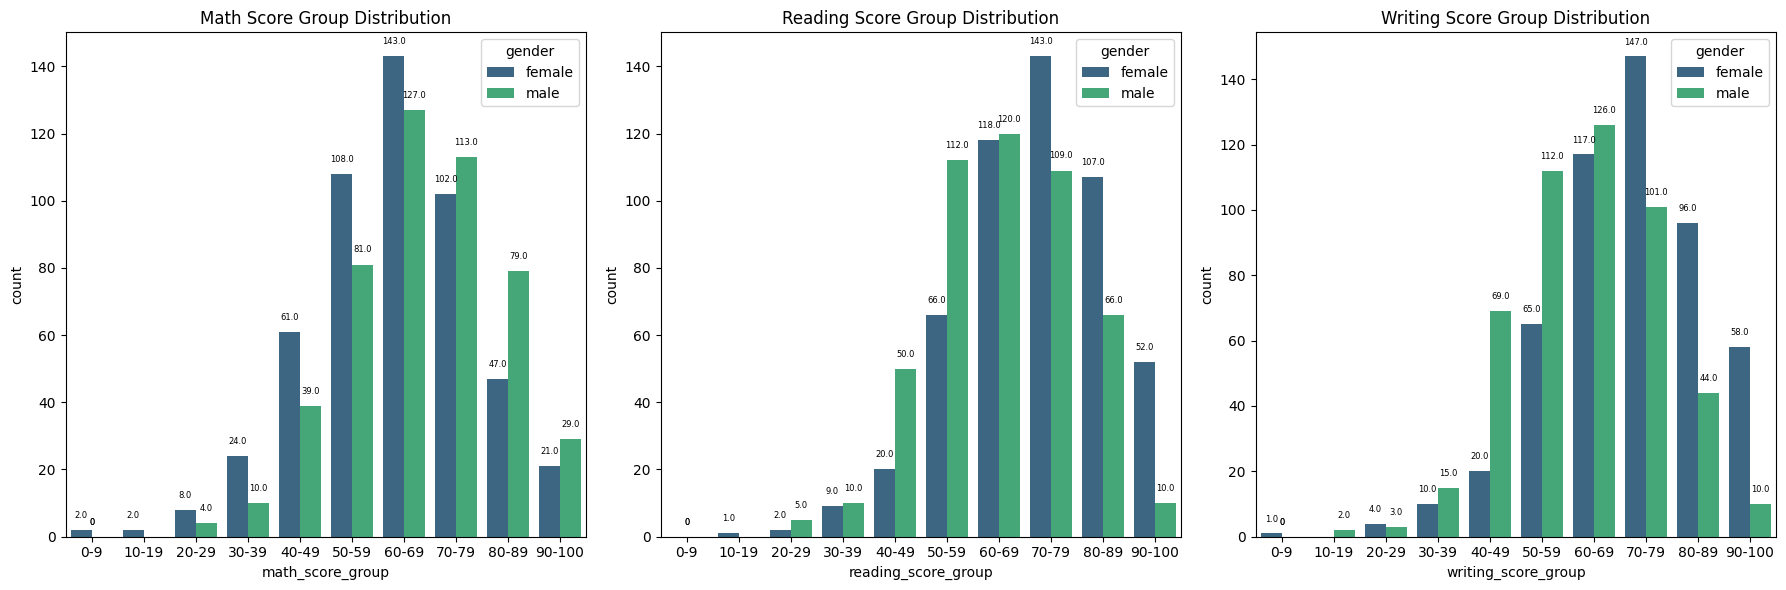

In [14]:
plt.figure(figsize=(18, 6))

# График для math_score_group
plt.subplot(1, 3, 1)
ax1 = sns.countplot(data=data, x="math_score_group", palette="viridis", hue="gender")
plt.title("Math Score Group Distribution")

# График для reading_score_group
plt.subplot(1, 3, 2)
ax2 = sns.countplot(data=data, x="reading_score_group", palette="viridis", hue="gender")
plt.title("Reading Score Group Distribution")

# График для writing_score_group
plt.subplot(1, 3, 3)
ax3 = sns.countplot(data=data, x="writing_score_group", palette="viridis", hue="gender")
plt.title("Writing Score Group Distribution")

def signatures(ax):
    for p in ax.patches:
        height = p.get_height()
        x = p.get_x() + p.get_width() / 2
        y = height + 3  
        ax.text(x, y, f'{height}', ha='center', va='bottom', fontsize=6)

signatures(ax1)
signatures(ax2)
signatures(ax3)

# Отображаем все графики
plt.tight_layout()
plt.show()


### Заметим, что девушки хуже справляются с математикой чем мужчины, но в чтении (вероятно литертуре) и в грамматике... лучше, так же замечу, что девушек больше, проверим

In [15]:
gender_count = data["gender"].value_counts()
print(gender_count)

gender
female    518
male      482
Name: count, dtype: int64


### Различие на самом деле есть, хотя не такое большое как я думал, хочу посмотреть на графики учитывая разницу в количестве людей

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   gender                       1000 non-null   object  
 1   race/ethnicity               1000 non-null   object  
 2   parental level of education  1000 non-null   object  
 3   lunch                        1000 non-null   object  
 4   test preparation course      1000 non-null   object  
 5   math score                   1000 non-null   int64   
 6   reading score                1000 non-null   int64   
 7   writing score                1000 non-null   int64   
 8   math_score_group             1000 non-null   category
 9   reading_score_group          1000 non-null   category
 10  writing_score_group          1000 non-null   category
dtypes: category(3), int64(3), object(5)
memory usage: 66.7+ KB


In [17]:
kol_female = 518
kol_male = 482

# Создание пустого DataFrame для хранения процентов
data_ = pd.DataFrame()

# Расчет процентов для math_score_group
gender_percentage = data.groupby('gender')['math_score_group'].value_counts(normalize=True).unstack()
data_["female_math_perc"] = gender_percentage.loc['female'] * 100
data_["male_math_perc"] = gender_percentage.loc['male'] * 100

# Расчет процентов для reading_score_group
gender_percentage = data.groupby('gender')['reading_score_group'].value_counts(normalize=True).unstack()
data_["female_reading_perc"] = gender_percentage.loc['female'] * 100
data_["male_reading_perc"] = gender_percentage.loc['male'] * 100

# Расчет процентов для writing_score_group
gender_percentage = data.groupby('gender')['writing_score_group'].value_counts(normalize=True).unstack()
data_["female_writing_perc"] = gender_percentage.loc['female'] * 100
data_["male_writing_perc"] = gender_percentage.loc['male'] * 100

# Информация о результатах
data_.info()

# Теперь данные в `data_` содержат проценты для каждой группы и гендера
print(data_)

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 10 entries, 0-9 to 90-100
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   female_math_perc     10 non-null     float64
 1   male_math_perc       10 non-null     float64
 2   female_reading_perc  10 non-null     float64
 3   male_reading_perc    10 non-null     float64
 4   female_writing_perc  10 non-null     float64
 5   male_writing_perc    10 non-null     float64
dtypes: float64(6)
memory usage: 1.0 KB
                  female_math_perc  male_math_perc  female_reading_perc  \
math_score_group                                                          
0-9                       0.386100        0.000000             0.000000   
10-19                     0.386100        0.000000             0.193050   
20-29                     1.544402        0.829876             0.386100   
30-39                     4.633205        2.074689             1.737452

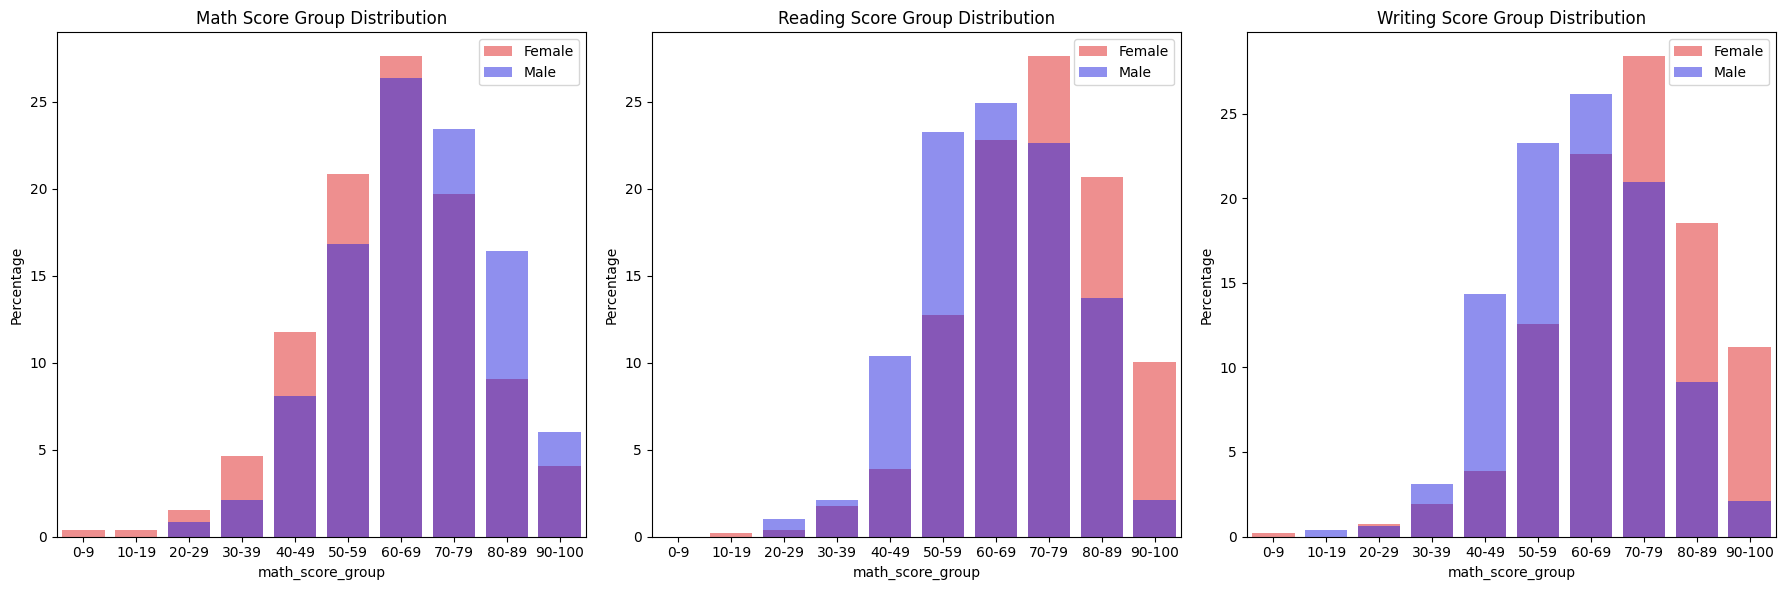

In [18]:
plt.figure(figsize=(18, 6))

# График для math_score_group с прозрачностью
plt.subplot(1, 3, 1)
sns.barplot(x=data_.index, y=data_['female_math_perc'], color='red', label="Female", alpha=0.5)  
sns.barplot(x=data_.index, y=data_['male_math_perc'], color='blue', label="Male", alpha=0.5)  
plt.title("Math Score Group Distribution")
plt.ylabel("Percentage")
plt.legend()

# График для reading_score_group с прозрачностью
plt.subplot(1, 3, 2)
sns.barplot(x=data_.index, y=data_['female_reading_perc'], color='red', label="Female", alpha=0.5)
sns.barplot(x=data_.index, y=data_['male_reading_perc'], color='blue', label="Male", alpha=0.5)
plt.title("Reading Score Group Distribution")
plt.ylabel("Percentage")
plt.legend()

# График для writing_score_group с прозрачностью
plt.subplot(1, 3, 3)
sns.barplot(x=data_.index, y=data_['female_writing_perc'], color='red', label="Female", alpha=0.5)
sns.barplot(x=data_.index, y=data_['male_writing_perc'], color='blue', label="Male", alpha=0.5)
plt.title("Writing Score Group Distribution")
plt.ylabel("Percentage")
plt.legend()

# Отображаем все графики
plt.tight_layout()
plt.show()



In [19]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   gender                       1000 non-null   object  
 1   race/ethnicity               1000 non-null   object  
 2   parental level of education  1000 non-null   object  
 3   lunch                        1000 non-null   object  
 4   test preparation course      1000 non-null   object  
 5   math score                   1000 non-null   int64   
 6   reading score                1000 non-null   int64   
 7   writing score                1000 non-null   int64   
 8   math_score_group             1000 non-null   category
 9   reading_score_group          1000 non-null   category
 10  writing_score_group          1000 non-null   category
dtypes: category(3), int64(3), object(5)
memory usage: 66.7+ KB


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,math_score_group,reading_score_group,writing_score_group
0,female,group B,bachelor's degree,standard,none,72,72,74,70-79,70-79,70-79
1,female,group C,some college,standard,completed,69,90,88,60-69,80-89,80-89
2,female,group B,master's degree,standard,none,90,95,93,80-89,90-100,90-100
3,male,group A,associate's degree,free/reduced,none,47,57,44,40-49,50-59,40-49
4,male,group C,some college,standard,none,76,78,75,70-79,70-79,70-79


Text(0.5, 1.0, 'Math score by groups of race')

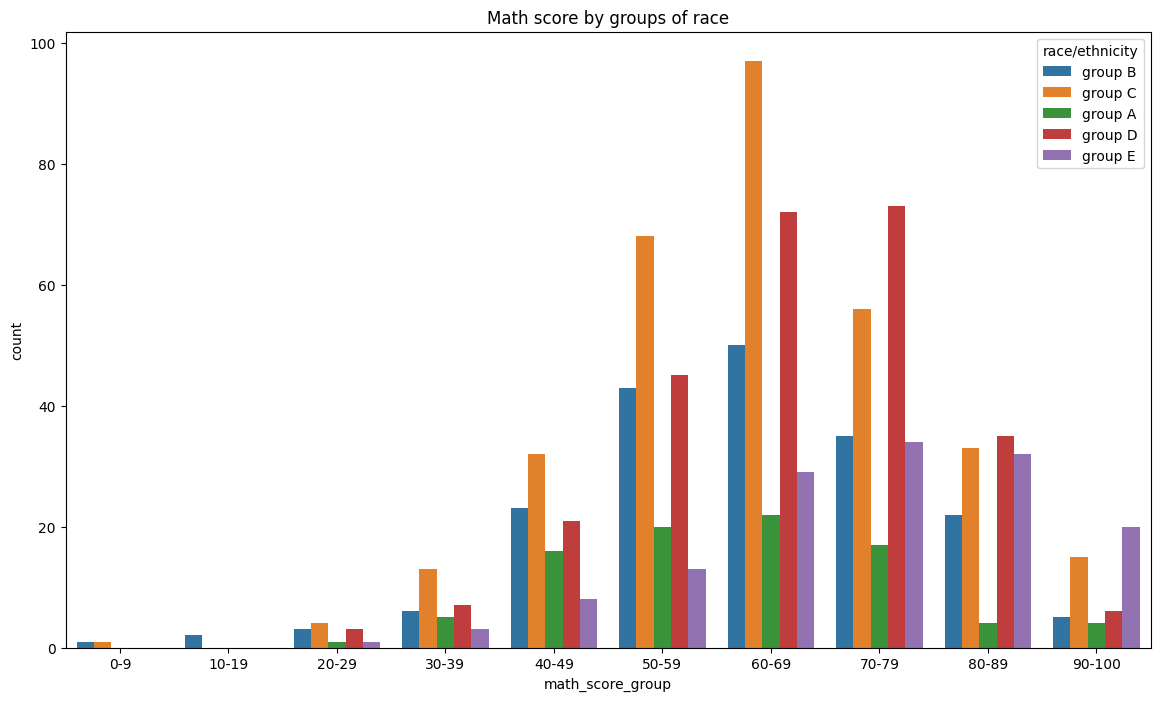

In [20]:
plt.figure(figsize=(14, 8))
sns.countplot(data = data, x = data["math_score_group"], hue = data["race/ethnicity"])
plt.title("Math score by groups of race")

In [21]:
group_value = data["race/ethnicity"].value_counts()
print("Количество людей в каждой группе:", group_value, sep = "\n")
print("\n","Всего людей: ", sum(group_value), sep = "\n")

Количество людей в каждой группе:
race/ethnicity
group C    319
group D    262
group B    190
group E    140
group A     89
Name: count, dtype: int64


Всего людей: 
1000


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   gender                       1000 non-null   object  
 1   race/ethnicity               1000 non-null   object  
 2   parental level of education  1000 non-null   object  
 3   lunch                        1000 non-null   object  
 4   test preparation course      1000 non-null   object  
 5   math score                   1000 non-null   int64   
 6   reading score                1000 non-null   int64   
 7   writing score                1000 non-null   int64   
 8   math_score_group             1000 non-null   category
 9   reading_score_group          1000 non-null   category
 10  writing_score_group          1000 non-null   category
dtypes: category(3), int64(3), object(5)
memory usage: 66.7+ KB


   race/ethnicity  percentage
0         group A    0.000000
1         group A    0.000000
2         group A    1.123596
3         group A    5.617978
4         group A   17.977528
5         group A   22.471910
6         group A   24.719101
7         group A   19.101124
8         group A    4.494382
9         group A    4.494382
10        group B    0.526316
11        group B    1.052632
12        group B    1.578947
13        group B    3.157895
14        group B   12.105263
15        group B   22.631579
16        group B   26.315789
17        group B   18.421053
18        group B   11.578947
19        group B    2.631579
20        group C    0.313480
21        group C    0.000000
22        group C    1.253918
23        group C    4.075235
24        group C   10.031348
25        group C   21.316614
26        group C   30.407524
27        group C   17.554859
28        group C   10.344828
29        group C    4.702194
30        group D    0.000000
31        group D    0.000000
32        

C:\Users\Alexey\AppData\Local\Temp\ipykernel_6112\2656039407.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = data.groupby(["race/ethnicity", "math_score_group"]).size().reset_index(name="count")


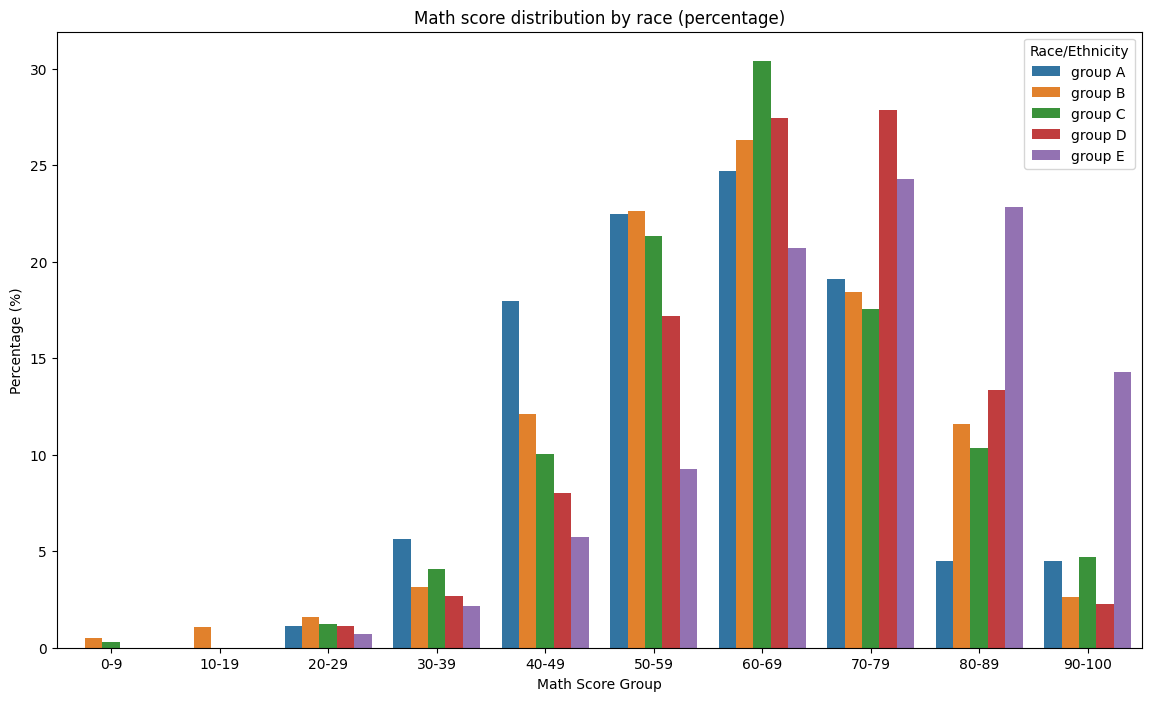

In [23]:
# Подсчет количества студентов в каждой группе оценок и расы
group_counts = data.groupby(["race/ethnicity", "math_score_group"]).size().reset_index(name="count")

# Нормализация: делим на общее количество студентов в каждой расовой группе
group_totals = data["race/ethnicity"].value_counts()
group_counts["percentage"] = group_counts.apply(lambda row: (row["count"] / group_totals[row["race/ethnicity"]]) * 100, axis=1)
print(group_counts[["race/ethnicity","percentage"]])

# Визуализация
plt.figure(figsize=(14, 8))
sns.barplot(data=group_counts, x="math_score_group", y="percentage", hue="race/ethnicity")

plt.title("Math score distribution by race (percentage)")
plt.ylabel("Percentage (%)")
plt.xlabel("Math Score Group")
plt.legend(title="Race/Ethnicity")
plt.show()


In [24]:
print(data[data['race/ethnicity'] == "group E"].count())
print(data[data['race/ethnicity'] == "group A"].count())


gender                         140
race/ethnicity                 140
parental level of education    140
lunch                          140
test preparation course        140
math score                     140
reading score                  140
writing score                  140
math_score_group               140
reading_score_group            140
writing_score_group            140
dtype: int64
gender                         89
race/ethnicity                 89
parental level of education    89
lunch                          89
test preparation course        89
math score                     89
reading score                  89
writing score                  89
math_score_group               89
reading_score_group            89
writing_score_group            89
dtype: int64


#### Из графика выше видно, что группа E сдает экзамены лучше других, а группа А чуть хуже, в целом раса слабо подходит для постановления предсказаний, хотя попробуем еще рассмотреть по гендеру.

C:\Users\Alexey\AppData\Local\Temp\ipykernel_6112\141429265.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = data.groupby(["race/ethnicity", "math_score_group", "gender"]).size().reset_index(name="count")


<Figure size 1600x800 with 0 Axes>

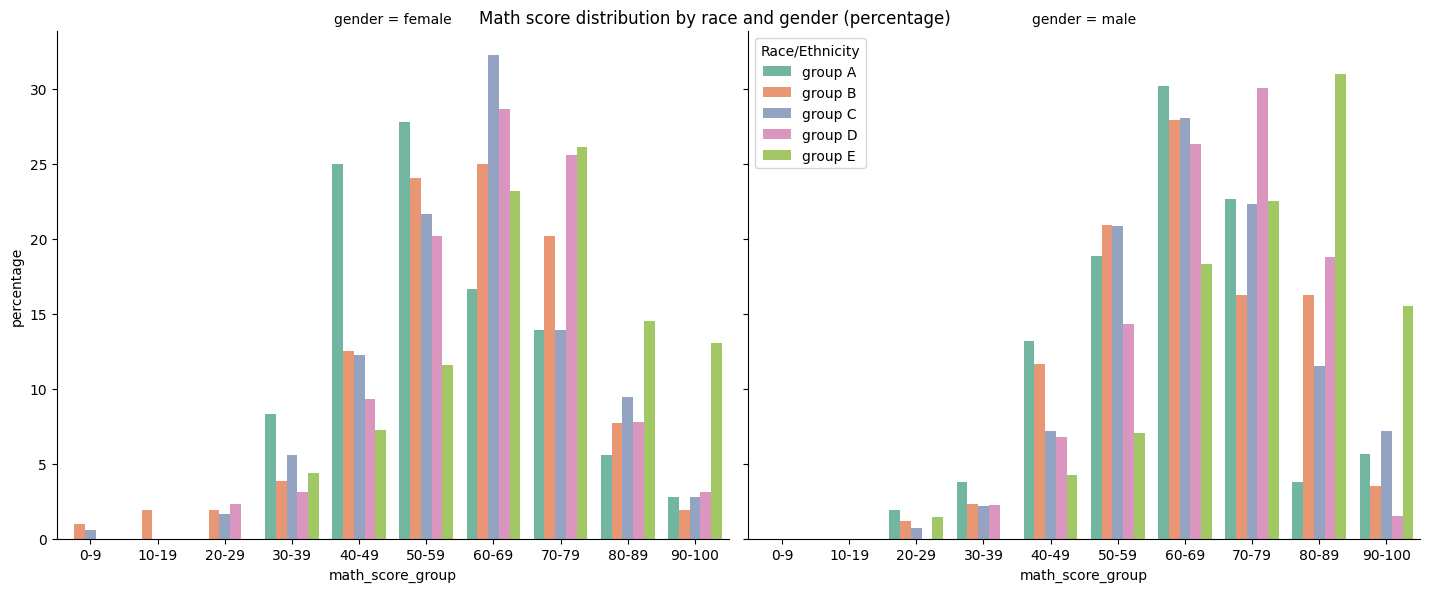

In [25]:
# Группировка по race/ethnicity, math_score_group и gender, считаем количество студентов
group_counts = data.groupby(["race/ethnicity", "math_score_group", "gender"]).size().reset_index(name="count")

# Общая численность в каждой комбинации race/ethnicity + gender
group_totals = data.groupby(["race/ethnicity", "gender"]).size()

# Нормализация: переводим в проценты внутри каждой группы race + gender
group_counts["percentage"] = group_counts.apply(lambda row: (row["count"] / group_totals[row["race/ethnicity"], row["gender"]]) * 100, axis=1)

# Визуализация, добавляем разделение по полу
plt.figure(figsize=(16, 8))

# Разделение по полу (чтобы отобразить два графика отдельно)
g = sns.FacetGrid(group_counts, col="gender", height=6, aspect=1.2)
g.map_dataframe(sns.barplot, x="math_score_group", y="percentage", hue="race/ethnicity", dodge=True, palette="Set2")

plt.suptitle("Math score distribution by race and gender (percentage)", fontsize=12)
plt.legend(title="Race/Ethnicity")
plt.show()


#### Разделение по полу тоже не дало результатов, в целом это было ожидаемо, так как при обучении модели на изначальных данных раса только ухудшала модель. Возможно добавив процентное соотношение в данные модель и станет чуть лучше работать, хотя предположу, что станет только хуже, для точного опрделения давайте посмотрим как будет по другим предметам.

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   gender                       1000 non-null   object  
 1   race/ethnicity               1000 non-null   object  
 2   parental level of education  1000 non-null   object  
 3   lunch                        1000 non-null   object  
 4   test preparation course      1000 non-null   object  
 5   math score                   1000 non-null   int64   
 6   reading score                1000 non-null   int64   
 7   writing score                1000 non-null   int64   
 8   math_score_group             1000 non-null   category
 9   reading_score_group          1000 non-null   category
 10  writing_score_group          1000 non-null   category
dtypes: category(3), int64(3), object(5)
memory usage: 66.7+ KB


C:\Users\Alexey\AppData\Local\Temp\ipykernel_6112\1479605051.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = data.groupby(["race/ethnicity", "reading_score_group", "gender"]).size().reset_index(name="count")


<Figure size 1600x800 with 0 Axes>

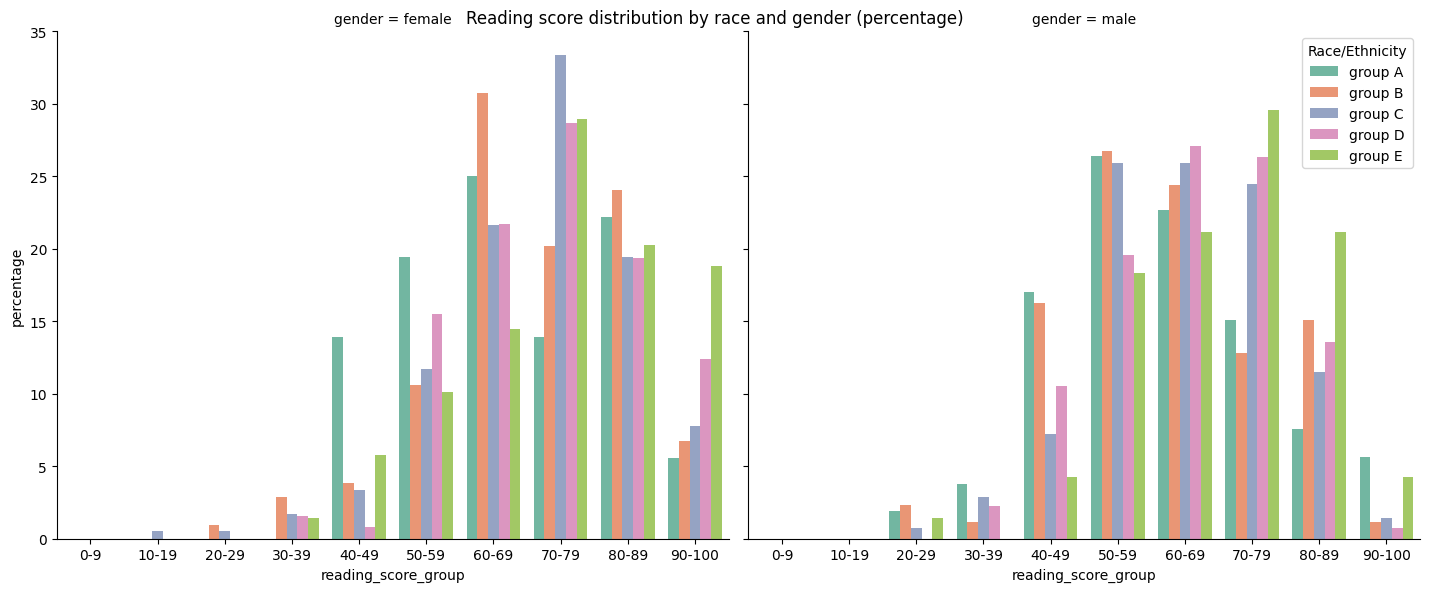

In [27]:
group_counts = data.groupby(["race/ethnicity", "reading_score_group", "gender"]).size().reset_index(name="count")

group_totals = data.groupby(["race/ethnicity", "gender"]).size()

group_counts["percentage"] = group_counts.apply(lambda row: (row["count"] / group_totals[row["race/ethnicity"], row["gender"]]) * 100, axis=1)

plt.figure(figsize=(16, 8))

g = sns.FacetGrid(group_counts, col="gender", height=6, aspect=1.2)
g.map_dataframe(sns.barplot, x="reading_score_group", y="percentage", hue="race/ethnicity", dodge=True, palette="Set2")

plt.suptitle("Reading score distribution by race and gender (percentage)", fontsize=12)
plt.legend(title="Race/Ethnicity")
plt.show()

#### Опять же группа E сдает чуть лучше, а А хуже, 2 другие группы примерно одинаково идут

C:\Users\Alexey\AppData\Local\Temp\ipykernel_6112\3949211613.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = data.groupby(["race/ethnicity", "writing_score_group", "gender"]).size().reset_index(name="count")


<Figure size 1600x800 with 0 Axes>

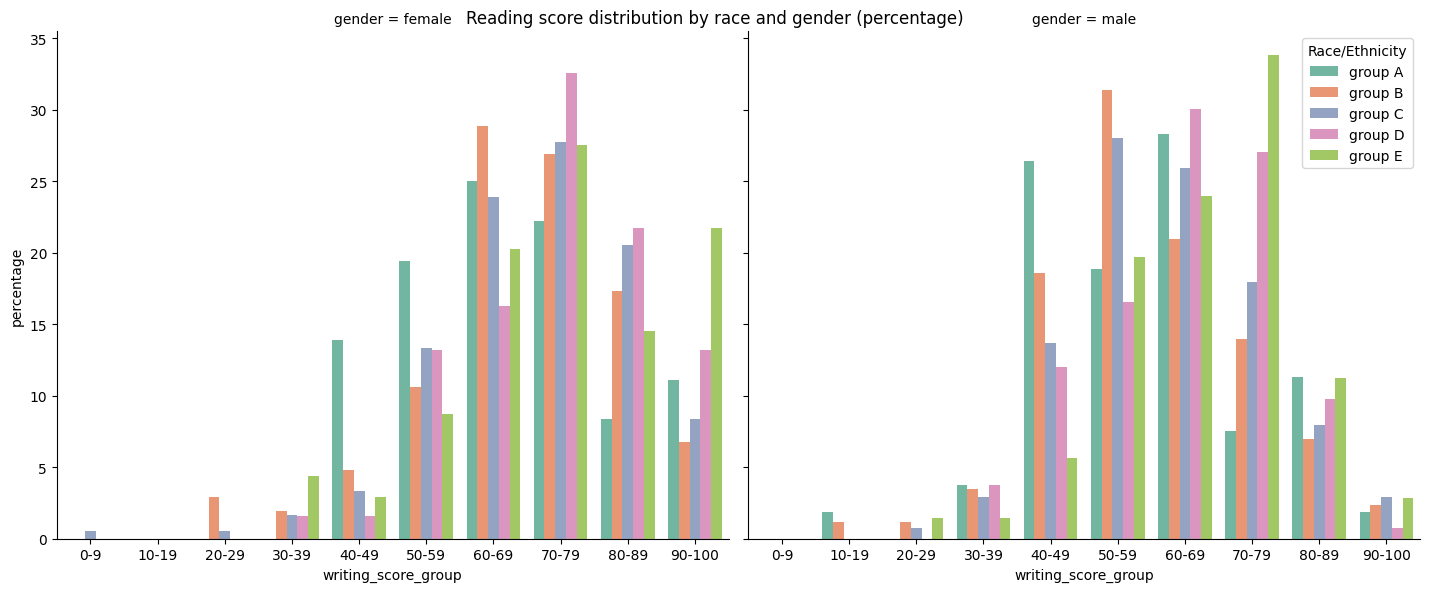

In [28]:
group_counts = data.groupby(["race/ethnicity", "writing_score_group", "gender"]).size().reset_index(name="count")

group_totals = data.groupby(["race/ethnicity", "gender"]).size()

group_counts["percentage"] = group_counts.apply(lambda row: (row["count"] / group_totals[row["race/ethnicity"], row["gender"]]) * 100, axis=1)

plt.figure(figsize=(16, 8))

g = sns.FacetGrid(group_counts, col="gender", height=6, aspect=1.2)
g.map_dataframe(sns.barplot, x="writing_score_group", y="percentage", hue="race/ethnicity", dodge=True, palette="Set2")

plt.suptitle("Reading score distribution by race and gender (percentage)", fontsize=12)
plt.legend(title="Race/Ethnicity")
plt.show()

#### Аналогично. Следовательно, я бы подкорректировал данные, чтобы это как-то учитывалось.

In [29]:
data["race/ethnicity"] = data["race/ethnicity"].apply(lambda x: 1 if x == "group E" else 0 if x == "group A" else 0.5)
print(data[data["race/ethnicity"] != 0.5])

     gender  race/ethnicity parental level of education         lunch  \
3      male             0.0          associate's degree  free/reduced   
13     male             0.0                some college      standard   
14   female             0.0             master's degree      standard   
25     male             0.0             master's degree  free/reduced   
32   female             1.0             master's degree  free/reduced   
..      ...             ...                         ...           ...   
987    male             1.0            some high school      standard   
988  female             0.0            some high school  free/reduced   
990    male             1.0                 high school  free/reduced   
994    male             0.0                 high school      standard   
995  female             1.0             master's degree      standard   

    test preparation course  math score  reading score  writing score  \
3                      none          47           

C:\Users\Alexey\AppData\Local\Temp\ipykernel_6112\2218984125.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = data.groupby(["race/ethnicity", "math_score_group"]).size().reset_index(name="count")


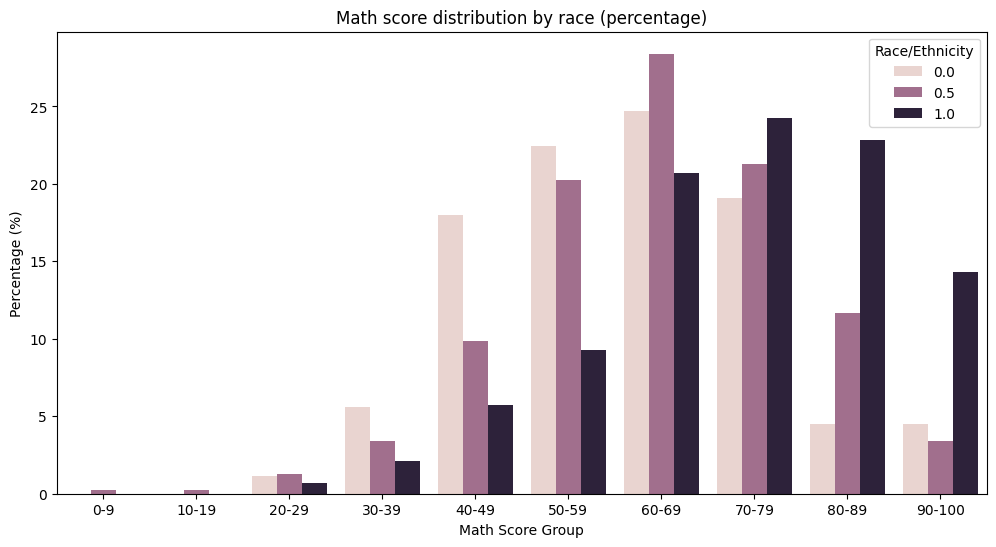

In [30]:
# Подсчет количества студентов в каждой группе оценок и расы
group_counts = data.groupby(["race/ethnicity", "math_score_group"]).size().reset_index(name="count")

# Нормализация: делим на общее количество студентов в каждой расовой группе
group_totals = data["race/ethnicity"].value_counts()
group_counts["percentage"] = group_counts.apply(lambda row: (row["count"] / group_totals[row["race/ethnicity"]]) * 100, axis=1)

# Визуализация
plt.figure(figsize=(12, 6))
sns.barplot(data=group_counts, x="math_score_group", y="percentage", hue="race/ethnicity")

plt.title("Math score distribution by race (percentage)")
plt.ylabel("Percentage (%)")
plt.xlabel("Math Score Group")
plt.legend(title="Race/Ethnicity")
plt.show()


#### Считаю что результат хороший, отчетливо видно, что группа "1" сдает лучше всех "0.5" средне, "0" хуже всех

#### Теперь проанализируем информацию через образование родителей

In [31]:
print(data["parental level of education"].value_counts())

parental level of education
some college          226
associate's degree    222
high school           196
some high school      179
bachelor's degree     118
master's degree        59
Name: count, dtype: int64


<Axes: xlabel='math_score_group', ylabel='count'>

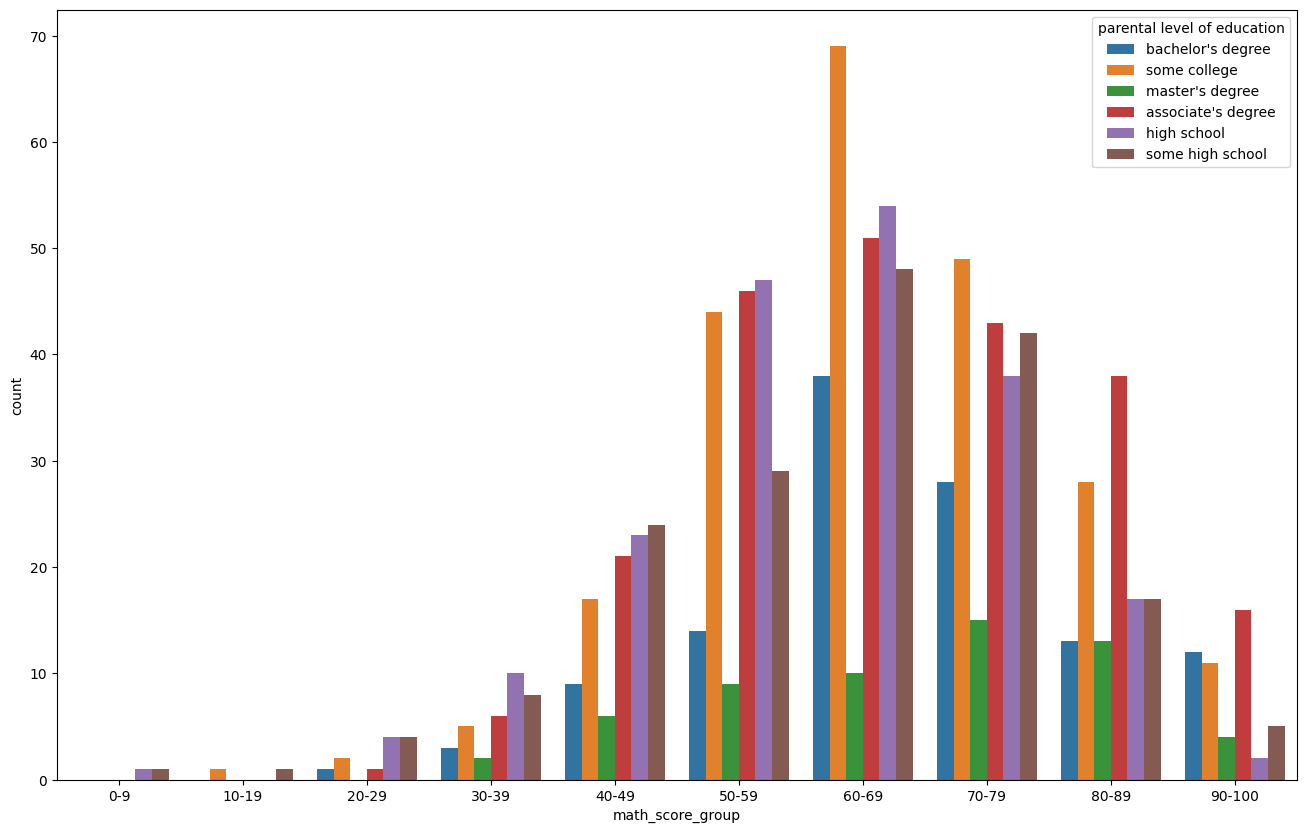

In [32]:
plt.figure(figsize = (16, 10))
sns.countplot(data=data, x = data["math_score_group"], hue = data["parental level of education"])

#### Опять же трудно что-то понячть, так как нет нормализации, видно, что "зеленых" довольно мало, что красные смещены в сторону высових баллов, рассмотрим графики в процентных соотношениях

C:\Users\Alexey\AppData\Local\Temp\ipykernel_6112\284554114.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = data.groupby(["parental level of education", "math_score_group"]).size().reset_index(name="count")


parental level of education
associate's degree    100.0
bachelor's degree     100.0
high school           100.0
master's degree       100.0
some college          100.0
some high school      100.0
Name: percentage, dtype: float64


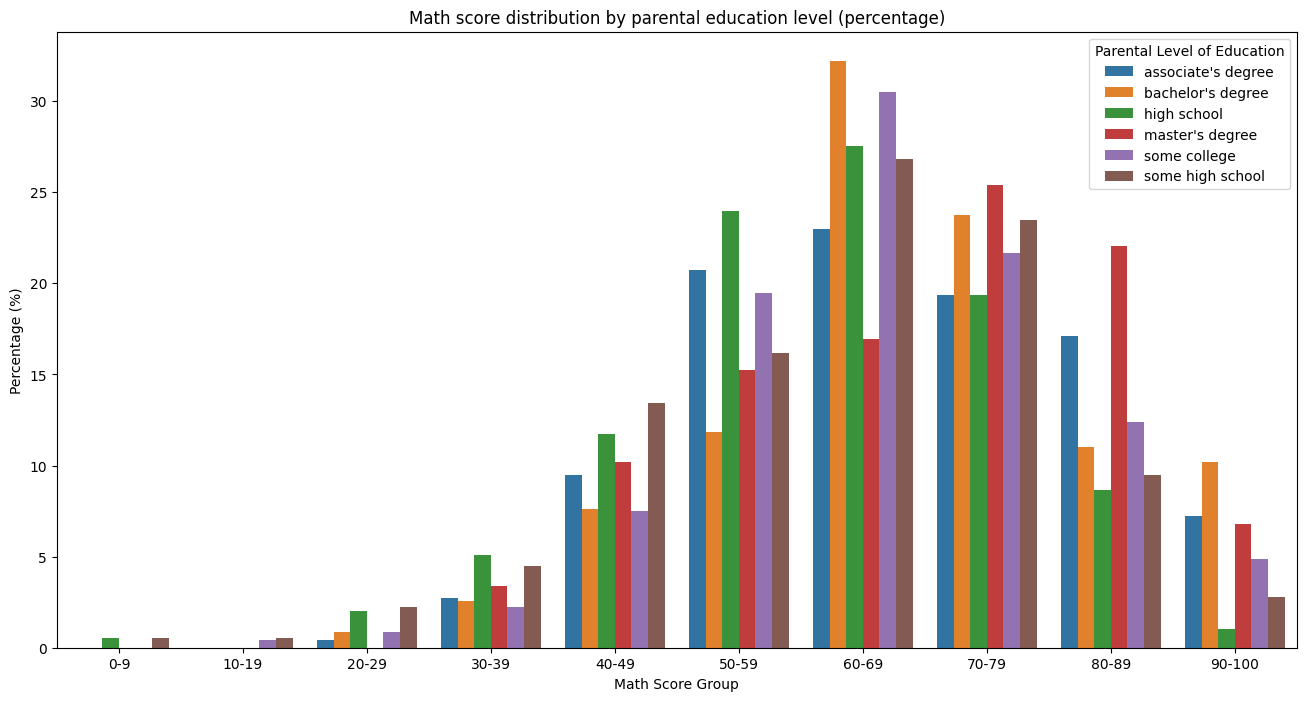

In [33]:
group_counts = data.groupby(["parental level of education", "math_score_group"]).size().reset_index(name="count")

group_totals = data.groupby("parental level of education").size()

group_counts["percentage"] = group_counts.apply(
    lambda row: (row["count"] / group_totals[row["parental level of education"]]) * 100, axis=1
)

print(group_counts.groupby("parental level of education")["percentage"].sum())

plt.figure(figsize=(16, 8))
sns.barplot(data=group_counts, x="math_score_group", y="percentage", hue="parental level of education")

plt.title("Math score distribution by parental education level (percentage)")
plt.ylabel("Percentage (%)")
plt.xlabel("Math Score Group")
plt.legend(title="Parental Level of Education")

plt.show()


#### Тут мы видим, что если у родителей master's degree или же associate's то результаты выше, а с high school ниже среднего.

C:\Users\Alexey\AppData\Local\Temp\ipykernel_6112\1854952543.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = data.groupby(["parental level of education", "reading_score_group"]).size().reset_index(name="count")


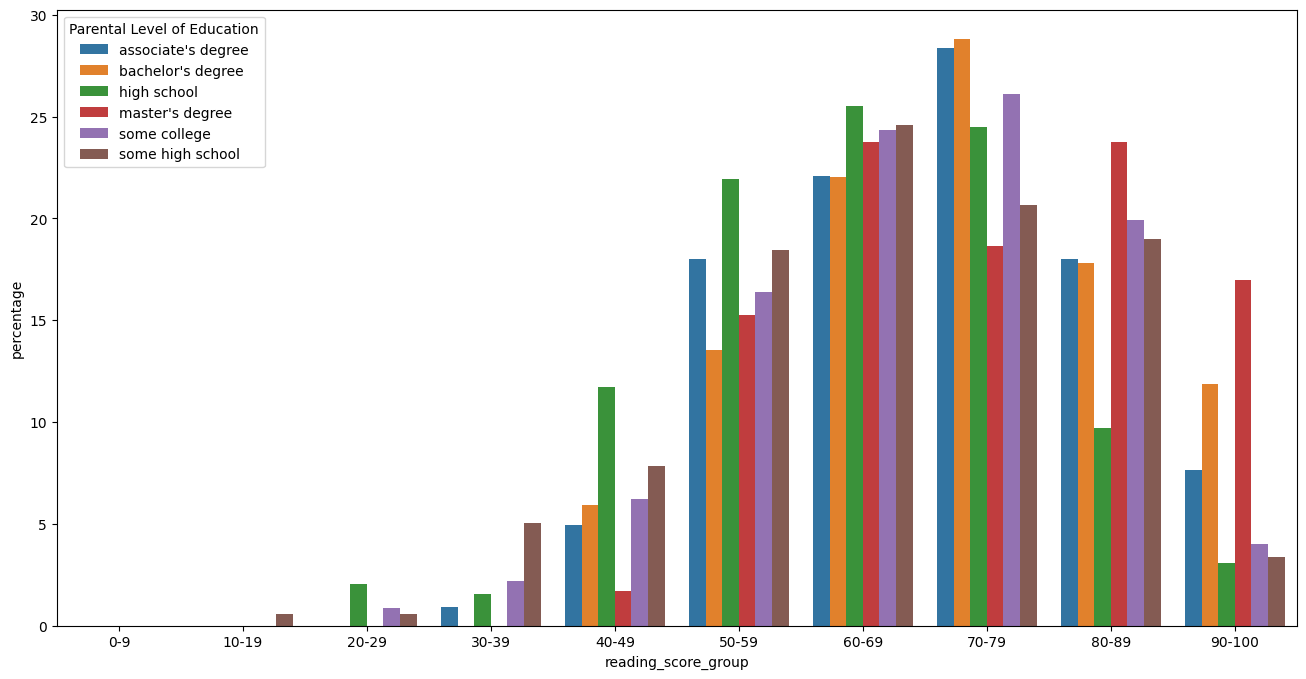

In [34]:
group_counts = data.groupby(["parental level of education", "reading_score_group"]).size().reset_index(name="count")

group_totals = data.groupby("parental level of education").size()

group_counts["percentage"] = group_counts.apply(
    lambda row: (row["count"] / group_totals[row["parental level of education"]]) * 100, axis=1
)

plt.figure(figsize=(16, 8))
sns.barplot(data=group_counts, x="reading_score_group", y="percentage", hue="parental level of education")

plt.legend(title="Parental Level of Education")

plt.show()

C:\Users\Alexey\AppData\Local\Temp\ipykernel_6112\2699721937.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = data.groupby(["parental level of education", "writing_score_group"]).size().reset_index(name="count")


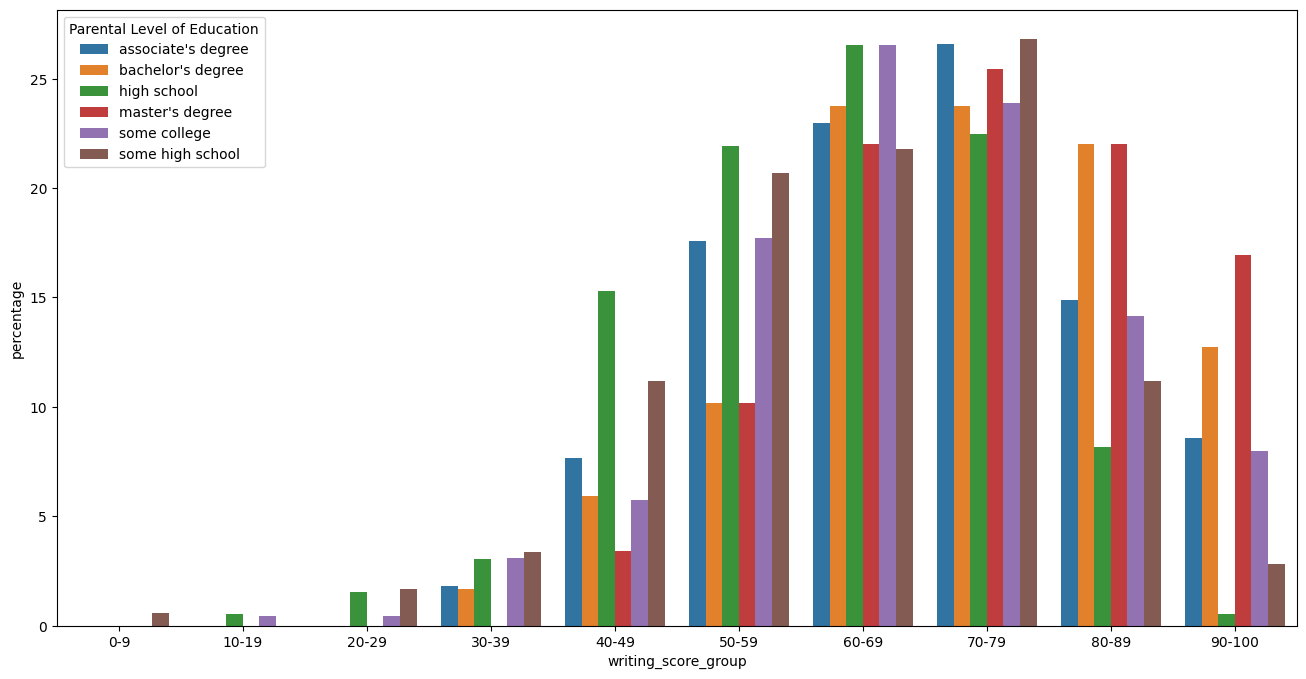

In [35]:
group_counts = data.groupby(["parental level of education", "writing_score_group"]).size().reset_index(name="count")

group_totals = data.groupby("parental level of education").size()

group_counts["percentage"] = group_counts.apply(
    lambda row: (row["count"] / group_totals[row["parental level of education"]]) * 100, axis=1
)

plt.figure(figsize=(16, 8))
sns.barplot(data=group_counts, x="writing_score_group", y="percentage", hue="parental level of education")

plt.legend(title="Parental Level of Education")

plt.show()

#### С бакалаворской степенью тоже как правило сдают лучше, а с associate's degree лишь чуть лучше некоторого колледжа.

#### Преобразуем данные учитывая наши выводы

In [36]:
data["parental level of education"] = data["parental level of education"].apply(lambda x: 0.8 if x == "bachelor's degree" 
else 0.9 if x == "master's degree" else 0.55 if x == "associate's degree" else 0.4 if "high school" else 0.5)
print(data["parental level of education"].head(10))

0    0.80
1    0.40
2    0.90
3    0.55
4    0.40
5    0.55
6    0.40
7    0.40
8    0.40
9    0.40
Name: parental level of education, dtype: float64


#### Возможно можно использовать K-means в качестве модели.

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   gender                       1000 non-null   object  
 1   race/ethnicity               1000 non-null   float64 
 2   parental level of education  1000 non-null   float64 
 3   lunch                        1000 non-null   object  
 4   test preparation course      1000 non-null   object  
 5   math score                   1000 non-null   int64   
 6   reading score                1000 non-null   int64   
 7   writing score                1000 non-null   int64   
 8   math_score_group             1000 non-null   category
 9   reading_score_group          1000 non-null   category
 10  writing_score_group          1000 non-null   category
dtypes: category(3), float64(2), int64(3), object(3)
memory usage: 66.7+ KB


#### Осталось проанализировать как влияет обед и тест перед экзаменом

In [38]:
data["lunch"].value_counts()

lunch
standard        645
free/reduced    355
Name: count, dtype: int64

C:\Users\Alexey\AppData\Local\Temp\ipykernel_6112\3964130081.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = data.groupby(["lunch", "math_score_group"]).size().reset_index(name="counts")


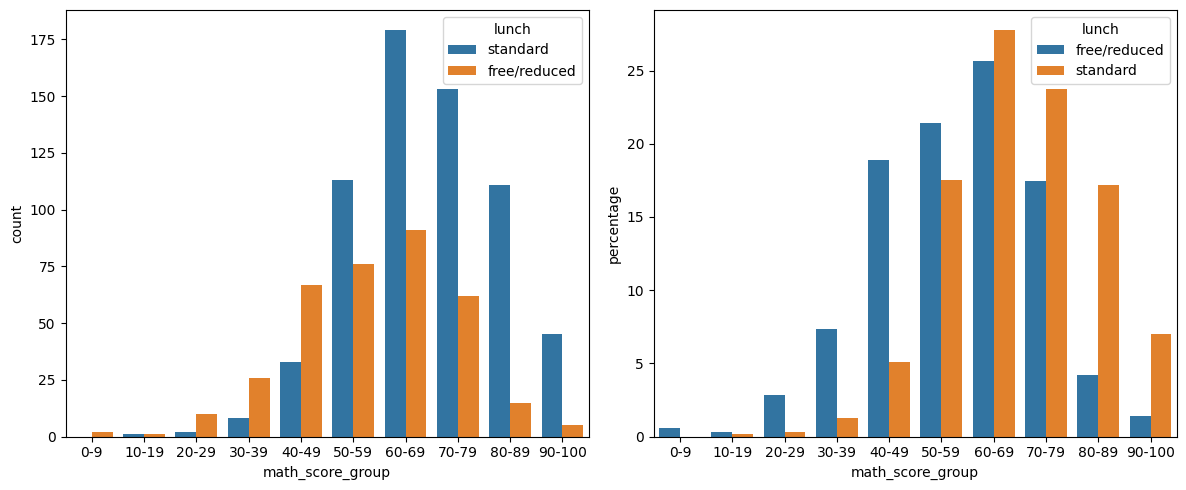

In [39]:
group_counts = data.groupby(["lunch", "math_score_group"]).size().reset_index(name="counts")
group_kol_human = data.groupby("lunch").size()
group_counts["percentage"] = group_counts.apply(lambda x: x["counts"] / group_kol_human[x["lunch"]] * 100, axis=1)

# Создание графиков
plt.figure(figsize=(12, 5))

# Первый график (количество учеников в каждой группе)
plt.subplot(1, 2, 1)
sns.countplot(data=data, x="math_score_group", hue="lunch")

# Второй график (процентное соотношение)
plt.subplot(1, 2, 2)
sns.barplot(data=group_counts, x="math_score_group", y="percentage", hue="lunch")

plt.tight_layout()  # Избегаем наложения графиков
plt.show()


#### Как мы видим, те кто хорошо поел лучше справились с экзаменом(значительно) запомним это, в дальнейшем используем данный атрибут для обучения.

In [40]:
data["test preparation course"].value_counts()

test preparation course
none         642
completed    358
Name: count, dtype: int64

C:\Users\Alexey\AppData\Local\Temp\ipykernel_6112\1142657271.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = data.groupby(["test preparation course", "math_score_group"]).size().reset_index(name="counts")
C:\Users\Alexey\AppData\Local\Temp\ipykernel_6112\1142657271.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = data.groupby(["test preparation course", "reading_score_group"]).size().reset_index(name="counts")
C:\Users\Alexey\AppData\Local\Temp\ipykernel_6112\1142657271.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a futu

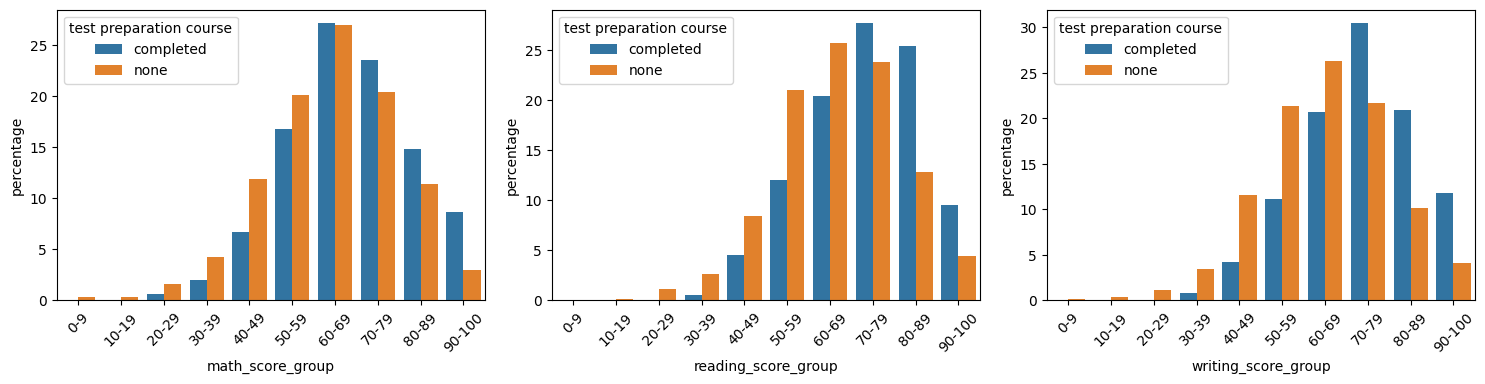

In [41]:
group_counts = data.groupby(["test preparation course", "math_score_group"]).size().reset_index(name="counts")
group_kol_human = data.groupby("test preparation course").size()
group_counts["percentage"] = group_counts.apply(lambda x: x["counts"] / group_kol_human[x["test preparation course"]] * 100, axis=1)

# Создание графиков
plt.figure(figsize=(15, 7))

plt.subplot(2, 3, 1)
sns.barplot(data=group_counts, x="math_score_group", y="percentage", hue="test preparation course")
plt.xticks(rotation=45)

group_counts = data.groupby(["test preparation course", "reading_score_group"]).size().reset_index(name="counts")
group_kol_human = data.groupby("test preparation course").size()
group_counts["percentage"] = group_counts.apply(lambda x: x["counts"] / group_kol_human[x["test preparation course"]] * 100, axis=1)

plt.subplot(2, 3, 2)
sns.barplot(data=group_counts, x="reading_score_group", y="percentage", hue="test preparation course")
plt.xticks(rotation=45)

group_counts = data.groupby(["test preparation course", "writing_score_group"]).size().reset_index(name="counts")
group_kol_human = data.groupby("test preparation course").size()
group_counts["percentage"] = group_counts.apply(lambda x: x["counts"] / group_kol_human[x["test preparation course"]] * 100, axis=1)

plt.subplot(2, 3, 3)
sns.barplot(data=group_counts, x="writing_score_group", y="percentage", hue="test preparation course")
plt.xticks(rotation=45)

plt.tight_layout()  # Избегаем наложения графиков
plt.show()


#### Кто сдавал подготовительный тест тот обычно лучше сдавал экзамен. 

In [42]:
data.head(20)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,math_score_group,reading_score_group,writing_score_group
0,female,0.5,0.80,standard,none,72,72,74,70-79,70-79,70-79
1,female,0.5,0.40,standard,completed,69,90,88,60-69,80-89,80-89
2,female,0.5,0.90,standard,none,90,95,93,80-89,90-100,90-100
3,male,0.0,0.55,free/reduced,none,47,57,44,40-49,50-59,40-49
4,male,0.5,0.40,standard,none,76,78,75,70-79,70-79,70-79
5,female,0.5,0.55,standard,none,71,83,78,70-79,80-89,70-79
6,female,0.5,0.40,standard,completed,88,95,92,80-89,90-100,90-100
7,male,0.5,0.40,free/reduced,none,40,43,39,30-39,40-49,30-39
8,male,0.5,0.40,free/reduced,completed,64,64,67,60-69,60-69,60-69
9,female,0.5,0.40,free/reduced,none,38,60,50,30-39,50-59,40-49


In [43]:
data["lunch"] = data["lunch"].apply(lambda x: 0.6 if x == "standard" else 0.4)
data["test preparation course"] = data["test preparation course"].apply(lambda x: 0.65 if x == "completed" else 0.5)
data.head(12)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,math_score_group,reading_score_group,writing_score_group
0,female,0.5,0.80,0.6,0.50,72,72,74,70-79,70-79,70-79
1,female,0.5,0.40,0.6,0.65,69,90,88,60-69,80-89,80-89
2,female,0.5,0.90,0.6,0.50,90,95,93,80-89,90-100,90-100
3,male,0.0,0.55,0.4,0.50,47,57,44,40-49,50-59,40-49
4,male,0.5,0.40,0.6,0.50,76,78,75,70-79,70-79,70-79
5,female,0.5,0.55,0.6,0.50,71,83,78,70-79,80-89,70-79
6,female,0.5,0.40,0.6,0.65,88,95,92,80-89,90-100,90-100
7,male,0.5,0.40,0.4,0.50,40,43,39,30-39,40-49,30-39
8,male,0.5,0.40,0.4,0.65,64,64,67,60-69,60-69,60-69
9,female,0.5,0.40,0.4,0.50,38,60,50,30-39,50-59,40-49


In [44]:
data["gender"] = pd.Categorical(data["gender"]).codes

In [45]:
data.head(5)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,math_score_group,reading_score_group,writing_score_group
0,0,0.5,0.80,0.6,0.50,72,72,74,70-79,70-79,70-79
1,0,0.5,0.40,0.6,0.65,69,90,88,60-69,80-89,80-89
2,0,0.5,0.90,0.6,0.50,90,95,93,80-89,90-100,90-100
3,1,0.0,0.55,0.4,0.50,47,57,44,40-49,50-59,40-49
4,1,0.5,0.40,0.6,0.50,76,78,75,70-79,70-79,70-79


#### Теперь попробуем на преобразованных данных обучить модель

In [46]:
# from itertools import combinations
# feature = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']

# param_grid = {
#     'n_estimators': [50, 100, 200],  
#     'max_depth': [None, 10, 20, 30],  
#     'min_samples_split': [2, 5, 10],  
#     'min_samples_leaf': [1, 2, 4]    
# }

In [47]:
# best_MSE = float("inf")
# for x in range(1,5):
#     for i in combinations(feature, x):

#         data_X = data[list(i)]
#         data_Y = data[['math score', 'reading score', 'writing score']]
#         X_train, x_test, Y_train, y_test = train_test_split(data_X, data_Y, test_size=20, random_state=42)

#         model = RandomForestRegressor(random_state=42)
#         grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, n_jobs= -1, scoring='neg_mean_squared_error')
#         grid_search.fit(X_train, Y_train)

#         best_rf = grid_search.best_estimator_
#         y_pred = best_rf.predict(x_test)
#         mse = mean_squared_error(y_test, y_pred)

#         if mse < best_MSE: 
#             joblib.dump(best_rf, "model_RF_after_processing.pkl")
#             best_MSE = mse
#             print(f"Test Mean Squared Error: {mse}")
#             print(f"Best feature: {list(i)}")

'''
Вывод:
Test Mean Squared Error: 251.9582227132142
Best feature: ['gender']
Test Mean Squared Error: 237.88061646434082
Best feature: ['gender', 'parental level of education']
Test Mean Squared Error: 221.56756261873088
Best feature: ['gender', 'parental level of education', 'test preparation course']
'''

        

"\nВывод:\nTest Mean Squared Error: 251.9582227132142\nBest feature: ['gender']\nTest Mean Squared Error: 237.88061646434082\nBest feature: ['gender', 'parental level of education']\nTest Mean Squared Error: 221.56756261873088\nBest feature: ['gender', 'parental level of education', 'test preparation course']\n"

In [48]:

# data_X = data[['gender', 'parental level of education', 'test preparation course']]
# data_Y = data[['math score', 'reading score', 'writing score']]
# X_train, x_test, Y_train, y_test = train_test_split(data_X, data_Y, test_size=20, random_state=42)

# model = RandomForestRegressor(random_state=42)
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, n_jobs= -1, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, Y_train)

# best_rf = grid_search.best_estimator_
# y_pred = best_rf.predict(x_test)
# mse = mean_squared_error(y_test, y_pred)

# joblib.dump(best_rf, "model_RF_after_processing.pkl")

# print(f"Test Mean Squared Error: {mse}")


#### Получилось интересно, первое это то, что параметры подобрались те же что и в начале, воторое это то, что результат стал чуть хуже, попробуем по другому преобразовать данные, не из своих личных мыслей, а дадим модели данные в том формате, в котором сами изучали, в процентах.

In [49]:
model = joblib.load("model_RF_after_processing.pkl") 

data_X = data[['gender', 'parental level of education', 'test preparation course']]
data_Y = data[['math score', 'reading score', 'writing score']]
X_train, x_test, Y_train, y_test = train_test_split(data_X, data_Y, test_size=20, random_state=42)

y_pred = model.predict(x_test)  
mse = mean_squared_error(y_test, y_pred)
print(f"Test Mean Squared Error: {mse}")


Test Mean Squared Error: 221.56756261873088


In [50]:

print(f"Mean MSE: {(baseline_mse_math + baseline_mse_reading + baseline_mse_writing) / 3}")

# Создаём DataFrame из y_pred
y_pred_df = pd.DataFrame(y_pred, columns=["Math predict", "Reading predict", "Writing predict"], index=y_test.index)

Mean MSE: 268.9700930167985


In [51]:
data_res = pd.concat([y_pred_df, y_test], axis=1)

print(data_res)

     Math predict  Reading predict  Writing predict  math score  \
521     61.884297        70.424780        69.124149          91   
737     65.337876        75.614267        76.457303          53   
740     66.748433        64.435387        62.366511          80   
660     65.617328        61.440845        57.924987          74   
411     71.055684        68.539061        67.715741          84   
678     68.412349        64.127467        61.198235          81   
626     74.256312        72.732282        72.135763          69   
513     65.337876        75.614267        76.457303          54   
859     68.412349        64.127467        61.198235          87   
136     71.055684        68.539061        67.715741          51   
811     65.617328        61.440845        57.924987          45   
76      65.617328        61.440845        57.924987          30   
636     65.337876        75.614267        76.457303          67   
973     60.209401        68.193898        66.905772          4

In [52]:
def fac(n):
    output = 1
    for i in range(2, n + 1):
        output *= i
    return output

def c(k, n):
    return fac(n) / (fac(k) * fac(n - k))

print(c(3, 5))

10.0


In [53]:
print(c(6, 10) * 2 ** 6 / c(6, 20))

0.34674922600619196
